In [250]:
import csv
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn.functional as F

In [251]:
oak_data = pd.read_csv('data.csv')
norl_data = pd.read_csv('new_orleans_data.csv')

/home/alex/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6,10,22,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/alex/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [252]:
oak_data.head()

,raw_row_number,date,time,location,lat,lng,beat,subject_age,subject_race,subject_sex,...,contraband_weapons,search_conducted,search_basis,reason_for_stop,use_of_force_description,raw_subject_sdrace,raw_subject_resultofencounter,raw_subject_searchconducted,raw_subject_typeofsearch,raw_subject_resultofsearch
0,17213,NaN,01:33:00,E. 28th St. & Park BLVD,37.803084,-122.237247,NaN,NaN,asian/pacific islander,female,...,NaN,False,NaN,Traffic Violation,NaN,A,"Citation,",No,NaN,NaN
1,17214,NaN,14:48:00,1759 SEMINARY AV,37.767568,-122.196820,NaN,NaN,black,male,...,False,True,other,Probation/Parole,NaN,B,"FI Report,",Yes,"Prob./Parole,",NaN
2,1,2013-04-01,00:00:00,31st St And Mlk Jr Way,37.820599,-122.270734,NaN,NaN,white,male,...,False,True,other,Traffic Violation,NaN,W,"Warning,",Yes,"Prob./Parole,",NaN
3,2,2013-04-01,00:01:00,3000 Block Of San Pablo Ave,37.821246,-122.276488,NaN,NaN,black,male,...,NaN,False,NaN,Traffic Violation,NaN,B,"FI Report,",No,NaN,NaN
4,19,2013-04-01,10:41:00,12th St/Broadway,37.802937,-122.271738,NaN,NaN,hispanic,female,...,NaN,False,NaN,Probable Cause,NaN,H,"Citation,",No,NaN,NaN


In [253]:
norl_data.head()

,raw_row_number,date,time,location,lat,lng,district,zone,subject_age,subject_race,...,search_person,search_vehicle,search_basis,reason_for_stop,vehicle_color,vehicle_make,vehicle_model,vehicle_year,raw_actions_taken,raw_subject_race
0,1,2010-01-01,01:11:00,NaN,NaN,NaN,6,E,26.0,black,...,False,False,NaN,TRAFFIC VIOLATION,BLACK,DODGE,CARAVAN,2005.0,NaN,BLACK
1,9087,2010-01-01,01:29:00,NaN,NaN,NaN,7,C,37.0,black,...,False,False,NaN,TRAFFIC VIOLATION,BLUE,NISSAN,MURANO,2005.0,NaN,BLACK
2,9086,2010-01-01,01:29:00,NaN,NaN,NaN,7,C,37.0,black,...,False,False,NaN,TRAFFIC VIOLATION,BLUE,NISSAN,MURANO,2005.0,NaN,BLACK
3,267,2010-01-01,14:00:00,NaN,NaN,NaN,7,I,96.0,black,...,False,False,NaN,TRAFFIC VIOLATION,GRAY,JEEP,GRAND CHEROKEE,2003.0,NaN,BLACK
4,2,2010-01-01,02:06:00,NaN,NaN,NaN,5,D,17.0,black,...,False,False,NaN,CALL FOR SERVICE,NaN,NaN,NaN,NaN,NaN,BLACK


In [254]:
oak_data['search_basis'].value_counts()

other             27402
probable cause    12712
consent            1043
Name: search_basis, dtype: int64

In [255]:
norl_data['search_basis'].value_counts()

other             52863
probable cause    12398
consent            5525
plain view         5005
Name: search_basis, dtype: int64

## Data Cleaning

In [256]:
# These will be the columns our final models use
columns = ['lat', 'lng', 'subject_age', 'subject_race', 'subject_sex', 
           'type', 'arrest_made', 'citation_issued', 'warning_issued', 
           'search_conducted', 'reason_for_stop',]

In [257]:
oak_data.columns


Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'beat',
       'subject_age', 'subject_race', 'subject_sex', 'officer_assignment',
       'type', 'arrest_made', 'citation_issued', 'warning_issued', 'outcome',
       'contraband_found', 'contraband_drugs', 'contraband_weapons',
       'search_conducted', 'search_basis', 'reason_for_stop',
       'use_of_force_description', 'raw_subject_sdrace',
       'raw_subject_resultofencounter', 'raw_subject_searchconducted',
       'raw_subject_typeofsearch', 'raw_subject_resultofsearch'],
      dtype='object')

In [258]:
norl_data.columns

Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'zone', 'subject_age', 'subject_race', 'subject_sex',
       'officer_assignment', 'type', 'arrest_made', 'citation_issued',
       'warning_issued', 'outcome', 'contraband_found', 'contraband_drugs',
       'contraband_weapons', 'frisk_performed', 'search_conducted',
       'search_person', 'search_vehicle', 'search_basis', 'reason_for_stop',
       'vehicle_color', 'vehicle_make', 'vehicle_model', 'vehicle_year',
       'raw_actions_taken', 'raw_subject_race'],
      dtype='object')

In [259]:
oak_clean = oak_data[columns]
norl_clean = norl_data[columns]

In [260]:
oak_clean.isna().sum()

lat                    114
lng                    114
subject_age         102724
subject_race             0
subject_sex             90
type                 20066
arrest_made              0
citation_issued          0
warning_issued           0
search_conducted         0
reason_for_stop          0
dtype: int64

In [261]:
norl_clean.isna().sum()

lat                 251684
lng                 251684
subject_age          12786
subject_race         11730
subject_sex          11730
type                149907
arrest_made              0
citation_issued          0
warning_issued           0
search_conducted         0
reason_for_stop          0
dtype: int64

### Standardize and One hot encode Reason For Stop

In [262]:
# Created based on https://cao-94612.s3.amazonaws.com/documents/2019-Stop-Data-Annual-Report-6Oct20-Final-Signed-1.pdf 
# and https://nopdnews.com/nopdnews/media/Assets/Policing-Data/Stop-and-Search-annual-report-2015.pdf
# and https://www.voiceofsandiego.org/topics/news/what-it-means-when-police-ask-are-you-on-probation/
reason_for_stop_map = {
    "TRAFFIC VIOLATION": "Traffic Violation",
    "Traffic Violation": "Traffic Violation",
    "CITIZEN CONTACT":   "Consensual Encounter",
    "CRIMINAL VIOLATION":"Probable Cause",
    "CALL FOR SERVICE": "Probable Cause",
    "SUSPECT PERSON" :"Probable Cause",
    "SUSPECT VEHICLE": "Probable Cause",
    "OTHER": "Other",
    "FLAGGED DOWN": "Consensual Encounter",
    "Probation/Parole": "Probable Cause", 
    "JUVENILE VIOLATION": "Probable Cause",
    "PRESENT AT CRIME SCENE": "Probable Cause",
    "Probable Cause": "Probable Cause",
    "Reasonable Suspicion": "Probable Cause",
    "Other": "Other",
    "Consensual Encounter": "Consensual Encounter",
    "Other-Consensual,": "Other",
    "Probable Cause,": "Probable Cause",
    
}
for i in set(oak_data['reason_for_stop']) | set(norl_data['reason_for_stop']):
    for j in i.split("|"):
        if j not in reason_for_stop_map:
            print(i, j)
print(set(reason_for_stop_map.values()))


{'Probable Cause', 'Consensual Encounter', 'Other', 'Traffic Violation'}


In [263]:
reason_for_stop_values = list(sorted(set(reason_for_stop_map.values())))
def reason_for_stop_clean(entries):
    res = [0, 0, 0, 0]
    for entry in entries.split("|"):
        mapped = reason_for_stop_map[entry]
        res[reason_for_stop_values.index(mapped)] = 1
    return np.array(res)
norl_clean['reason_for_stop'] = norl_data['reason_for_stop'].apply(reason_for_stop_clean)
norl_clean['reason_for_stop'].apply(tuple).value_counts()

/home/alex/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0, 0, 0, 1)    292318
(0, 0, 1, 0)    174861
(0, 1, 0, 0)     24528
(1, 0, 0, 0)     20378
(0, 0, 1, 1)         5
(0, 1, 0, 1)         2
Name: reason_for_stop, dtype: int64

In [264]:
oak_clean['reason_for_stop'] = oak_data['reason_for_stop'].apply(reason_for_stop_clean)
oak_clean['reason_for_stop'].apply(tuple).value_counts()

/home/alex/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(0, 0, 0, 1)    99847
(0, 0, 1, 0)    29306
(1, 0, 0, 0)     3998
(0, 0, 1, 1)      153
(1, 0, 1, 0)       69
(1, 0, 0, 1)       33
(0, 1, 0, 0)        1
Name: reason_for_stop, dtype: int64

In [265]:
oak_clean[reason_for_stop_values] = pd.DataFrame(np.stack(np.array(oak_clean['reason_for_stop'].values), axis=0))
oak_clean.head()

/home/alex/.local/lib/python3.5/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,lat,lng,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,warning_issued,search_conducted,reason_for_stop,Consensual Encounter,Other,Probable Cause,Traffic Violation
0,37.803084,-122.237247,NaN,asian/pacific islander,female,vehicular,False,True,False,False,"[0, 0, 0, 1]",0,0,0,1
1,37.767568,-122.196820,NaN,black,male,NaN,False,False,False,True,"[0, 0, 1, 0]",0,0,1,0
2,37.820599,-122.270734,NaN,white,male,vehicular,False,False,True,True,"[0, 0, 0, 1]",0,0,0,1
3,37.821246,-122.276488,NaN,black,male,vehicular,False,False,False,False,"[0, 0, 0, 1]",0,0,0,1
4,37.802937,-122.271738,NaN,hispanic,female,NaN,False,True,False,False,"[0, 0, 1, 0]",0,0,1,0


In [266]:
norl_clean[reason_for_stop_values] = pd.DataFrame(np.stack(np.array(norl_clean['reason_for_stop'].values), axis=0))
norl_clean.head()

,lat,lng,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,warning_issued,search_conducted,reason_for_stop,Consensual Encounter,Other,Probable Cause,Traffic Violation
0,NaN,NaN,26.0,black,female,vehicular,False,False,False,False,"[0, 0, 0, 1]",0,0,0,1
1,NaN,NaN,37.0,black,male,vehicular,False,False,False,False,"[0, 0, 0, 1]",0,0,0,1
2,NaN,NaN,37.0,black,male,vehicular,False,False,False,False,"[0, 0, 0, 1]",0,0,0,1
3,NaN,NaN,96.0,black,male,vehicular,False,False,False,False,"[0, 0, 0, 1]",0,0,0,1
4,NaN,NaN,17.0,black,male,NaN,False,False,False,False,"[0, 0, 1, 0]",0,0,1,0


In [267]:
norl_clean = norl_clean.drop(columns=['reason_for_stop'])
oak_clean = oak_clean.drop(columns=['reason_for_stop'])

### Take care of NA's

In [268]:
oak_clean.isna().sum()

lat                        114
lng                        114
subject_age             102724
subject_race                 0
subject_sex                 90
type                     20066
arrest_made                  0
citation_issued              0
warning_issued               0
search_conducted             0
Consensual Encounter         0
Other                        0
Probable Cause               0
Traffic Violation            0
dtype: int64

In [269]:
norl_clean.isna().sum()

lat                     251684
lng                     251684
subject_age              12786
subject_race             11730
subject_sex              11730
type                    149907
arrest_made                  0
citation_issued              0
warning_issued               0
search_conducted             0
Consensual Encounter         0
Other                        0
Probable Cause               0
Traffic Violation            0
dtype: int64

In [270]:
norl_clean = norl_clean.dropna(subset=["subject_race","subject_sex", "type"]).reset_index(drop=True)
oak_clean = oak_clean.dropna(subset=["subject_race","subject_sex", "type"]).reset_index(drop=True)


In [271]:
def set_mean_to_avg(frame, column):
    frame[column] = frame[column].fillna(frame[column].mean())

set_mean_to_avg(oak_clean, 'subject_age')
set_mean_to_avg(oak_clean, 'lat')
set_mean_to_avg(oak_clean, 'lng')

set_mean_to_avg(norl_clean, 'subject_age')
set_mean_to_avg(norl_clean, 'lat')
set_mean_to_avg(norl_clean, 'lng')


In [272]:
oak_clean.isna().sum(), oak_clean.shape

(lat                     0
 lng                     0
 subject_age             0
 subject_race            0
 subject_sex             0
 type                    0
 arrest_made             0
 citation_issued         0
 warning_issued          0
 search_conducted        0
 Consensual Encounter    0
 Other                   0
 Probable Cause          0
 Traffic Violation       0
 dtype: int64, (113263, 14))

In [273]:
norl_clean.isna().sum(), norl_clean.shape

(lat                     0
 lng                     0
 subject_age             0
 subject_race            0
 subject_sex             0
 type                    0
 arrest_made             0
 citation_issued         0
 warning_issued          0
 search_conducted        0
 Consensual Encounter    0
 Other                   0
 Probable Cause          0
 Traffic Violation       0
 dtype: int64, (351904, 14))

### Rest of one hot encoding

In [274]:
oak_clean['outcome'] = ((oak_clean['citation_issued']) | (oak_clean['arrest_made'])).astype(int)
norl_clean['outcome'] = ((norl_clean['citation_issued']) | (norl_clean['arrest_made'])).astype(int)

In [275]:
norl_clean = norl_clean.drop(columns=['citation_issued', 'arrest_made', 'warning_issued'])
oak_clean = oak_clean.drop(columns=['citation_issued', 'arrest_made', 'warning_issued'])

In [276]:
oak_clean['search_conducted'] = oak_clean['search_conducted'].astype('int')
norl_clean['search_conducted'] = norl_clean['search_conducted'].astype('int')

In [277]:
oak_clean.head()

,lat,lng,subject_age,subject_race,subject_sex,type,search_conducted,Consensual Encounter,Other,Probable Cause,Traffic Violation,outcome
0,37.803084,-122.237247,33.178262,asian/pacific islander,female,vehicular,0,0,0,0,1,1
1,37.820599,-122.270734,33.178262,white,male,vehicular,1,0,0,0,1,0
2,37.821246,-122.276488,33.178262,black,male,vehicular,0,0,0,0,1,0
3,37.812199,-122.276388,33.178262,white,male,vehicular,0,0,0,0,1,0
4,37.815760,-122.285080,33.178262,black,male,vehicular,1,0,0,0,1,1


In [278]:
oak_clean['type'] = (oak_clean['type'] == 'vehicular').astype(int)
oak_clean['subject_sex'] = (oak_clean['subject_sex'] == 'female').astype(int)

norl_clean['type'] = (norl_clean['type'] == 'vehicular').astype(int)
norl_clean['subject_sex'] = (norl_clean['subject_sex'] == 'female').astype(int)



In [279]:
oak_clean.head()

,lat,lng,subject_age,subject_race,subject_sex,type,search_conducted,Consensual Encounter,Other,Probable Cause,Traffic Violation,outcome
0,37.803084,-122.237247,33.178262,asian/pacific islander,1,1,0,0,0,0,1,1
1,37.820599,-122.270734,33.178262,white,0,1,1,0,0,0,1,0
2,37.821246,-122.276488,33.178262,black,0,1,0,0,0,0,1,0
3,37.812199,-122.276388,33.178262,white,0,1,0,0,0,0,1,0
4,37.815760,-122.285080,33.178262,black,0,1,1,0,0,0,1,1


In [280]:
races = list(sorted(set(oak_clean['subject_race']) | set(norl_clean['subject_race'])))
races

['asian/pacific islander', 'black', 'hispanic', 'other', 'unknown', 'white']

In [281]:
def race_clean(entry):
    res = [0] * len(races)
    res[races.index(entry)] = 1
    return res
oak_clean[races] = pd.DataFrame(np.stack(np.array(oak_clean['subject_race'].apply(race_clean).values), axis=0))
norl_clean[races] = pd.DataFrame(np.stack(np.array(norl_clean['subject_race'].apply(race_clean).values), axis=0))

oak_clean = oak_clean.drop(columns=['subject_race'])
norl_clean = norl_clean.drop(columns=['subject_race'])


In [282]:
norl_clean.head()

,lat,lng,subject_age,subject_sex,type,search_conducted,Consensual Encounter,Other,Probable Cause,Traffic Violation,outcome,asian/pacific islander,black,hispanic,other,unknown,white
0,29.969482,-90.063164,26.0,1,1,0,0,0,0,1,0,0,1,0,0,0,0
1,29.969482,-90.063164,37.0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2,29.969482,-90.063164,37.0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3,29.969482,-90.063164,96.0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
4,29.969482,-90.063164,32.0,0,1,0,0,0,0,1,0,0,1,0,0,0,0


In [283]:
oak_clean.isna().sum(), oak_clean.shape

(lat                       0
 lng                       0
 subject_age               0
 subject_sex               0
 type                      0
 search_conducted          0
 Consensual Encounter      0
 Other                     0
 Probable Cause            0
 Traffic Violation         0
 outcome                   0
 asian/pacific islander    0
 black                     0
 hispanic                  0
 other                     0
 unknown                   0
 white                     0
 dtype: int64, (113263, 17))

In [284]:
norl_clean.isna().sum(), norl_clean.shape

(lat                       0
 lng                       0
 subject_age               0
 subject_sex               0
 type                      0
 search_conducted          0
 Consensual Encounter      0
 Other                     0
 Probable Cause            0
 Traffic Violation         0
 outcome                   0
 asian/pacific islander    0
 black                     0
 hispanic                  0
 other                     0
 unknown                   0
 white                     0
 dtype: int64, (351904, 17))

In [285]:
oak_clean.describe()

,lat,lng,subject_age,subject_sex,type,search_conducted,Consensual Encounter,Other,Probable Cause,Traffic Violation,outcome,asian/pacific islander,black,hispanic,other,unknown,white
count,113263.000000,113263.000000,113263.000000,113263.000000,113263.000000,113263.000000,113263.000000,113263.0,113263.000000,113263.000000,113263.000000,113263.000000,113263.000000,113263.000000,113263.000000,113263.0,113263.000000
mean,37.787662,-122.228447,33.178262,0.260058,0.937473,0.253975,0.013720,0.0,0.105515,0.882645,0.525485,0.063587,0.574371,0.206908,0.035104,0.0,0.120030
std,0.028267,0.043225,6.871834,0.438668,0.242111,0.435286,0.116328,0.0,0.307218,0.321844,0.499352,0.244016,0.494440,0.405091,0.184044,0.0,0.324998
min,37.428687,-122.469412,10.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,37.765299,-122.268980,33.178262,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,37.786240,-122.229697,33.178262,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
75%,37.809229,-122.190387,33.178262,1.000000,1.000000,1.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
max,38.037528,-119.249135,97.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [286]:
norl_clean.describe()

,lat,lng,subject_age,subject_sex,type,search_conducted,Consensual Encounter,Other,Probable Cause,Traffic Violation,outcome,asian/pacific islander,black,hispanic,other,unknown,white
count,351904.000000,351904.000000,351904.000000,351904.000000,351904.000000,351904.000000,351904.0,351904.0,351904.000000,351904.000000,351904.000000,351904.000000,351904.000000,351904.000000,351904.000000,351904.000000,351904.000000
mean,29.969482,-90.063164,34.521643,0.302983,0.819525,0.111428,0.0,0.0,0.196244,0.803756,0.412368,0.008778,0.710290,0.028479,0.000753,0.007655,0.244044
std,0.025303,0.033076,13.095821,0.459549,0.384583,0.314662,0.0,0.0,0.397156,0.397156,0.492261,0.093279,0.453628,0.166338,0.027431,0.087160,0.429519
min,29.656656,-93.196423,10.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.958167,-90.075540,24.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.969482,-90.063164,31.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,29.969482,-90.062967,43.000000,1.000000,1.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,30.283410,-89.740142,110.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Test Train Split

In [287]:
inputs = list(oak_clean.columns)
label = 'outcome'
inputs.remove(label)
print(inputs)

['lat', 'lng', 'subject_age', 'subject_sex', 'type', 'search_conducted', 'Consensual Encounter', 'Other', 'Probable Cause', 'Traffic Violation', 'asian/pacific islander', 'black', 'hispanic', 'other', 'unknown', 'white']


In [288]:
X_oak = oak_clean[inputs]
y_oak = oak_clean[label]

X_train_oak, X_test_oak, y_train_oak, y_test_oak = train_test_split(X_oak, y_oak, test_size=0.1, random_state=42)

X_norl = norl_clean[inputs]
y_norl = norl_clean[label]


X_train_norl, X_test_norl, y_train_norl, y_test_norl = train_test_split(X_norl, y_norl, test_size=0.1, random_state=42)


## Models

### Linear Model

In [289]:
LinRegOak = LinearRegression().fit(X_train_oak, y_train_oak)

print("Linear Regression Oakland")
print("train accuracy: ",  np.mean((LinRegOak.predict(X_train_oak) > .5) == y_train_oak))
print("test accuracy: ", np.mean((LinRegOak.predict(X_test_oak) > .5) == y_test_oak))

LinRegNorl = LinearRegression().fit(X_train_norl, y_train_norl)

print("Linear Regression New Orleans")
print("train accuracy: ",  np.mean((LinRegNorl.predict(X_train_norl) > .5) == y_train_norl))
print("test accuracy: ", np.mean((LinRegNorl.predict(X_test_norl) > .5) == y_test_norl))

Linear Regression Oakland
train accuracy:  0.5650800502275938
test accuracy:  0.565904476030723
Linear Regression New Orleans
train accuracy:  0.668384310085156
test accuracy:  0.6712511721747038


### Tree Model

In [290]:
xgbrOak = xgb.XGBClassifier(learning_rate = .15, booster = "gbtree", max_depth = 15, eta = 0.5, n_estimators = 150) 
xgbrOak.fit(X_train_oak, y_train_oak)

print("Gradient Boosting Oakland")
print("train accuracy: ",  np.mean(xgbrOak.predict(X_train_oak) == y_train_oak))
print("test accuracy: ", np.mean(xgbrOak.predict(X_test_oak) == y_test_oak))

Gradient Boosting Oakland
train accuracy:  0.77953814157903
test accuracy:  0.6129601836320296


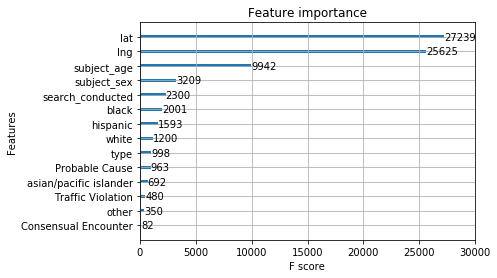

In [291]:
plot_importance(xgbrOak)
plt.show()

In [292]:
xgbrNorl = xgb.XGBClassifier(learning_rate = .1, booster = "gbtree", max_depth = 15, eta = 0.5, n_estimators = 150) 
xgbrNorl.fit(X_train_norl, y_train_norl)

print("Gradient Boosting Oakland")
print("train accuracy: ",  np.mean(xgbrNorl.predict(X_train_norl) == y_train_norl))
print("test accuracy: ", np.mean(xgbrNorl.predict(X_test_norl) == y_test_norl))

Gradient Boosting Oakland
train accuracy:  0.7768768569651388
test accuracy:  0.7105225767952034


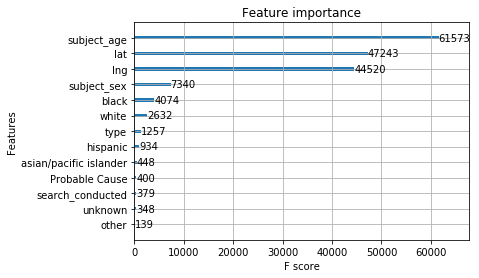

In [293]:
plot_importance(xgbrNorl)
plt.show()

## Moving Automated Cops Around

In [298]:
print("GB Oakland cop in New Orleans test accuracy: ", np.mean(xgbrOak.predict(X_test_norl) == y_test_norl))
print("GB New Orleans cop in Oakland test accuracy: ", np.mean(xgbrNorl.predict(X_test_oak) == y_test_oak))


GB Oakland cop in New Orleans test accuracy:  0.5695774487795174
GB New Orleans cop in Oakland test accuracy:  0.4694093758276684


In [299]:
np.mean(xgbrNorl.predict(X_test_oak))

0.28577734616403283

In [301]:
np.mean(xgbrOak.predict(X_test_norl))

0.28467505896393963

In [304]:
np.mean(oak_clean['black']), np.mean(norl_clean['black'])

(0.5743711538631328, 0.7102903064472129)

In [305]:
np.mean(oak_clean['subject_sex']), np.mean(norl_clean['subject_sex'])

(0.26005844803686995, 0.30298319996362644)

In [309]:
np.mean(oak_clean[oak_clean['black'] == 1]['outcome']), np.mean(norl_clean[norl_clean['black'] == 1]['outcome'])

(0.479348243793713, 0.4059226897749186)

In [316]:
print("Oakland percent black")
print(np.mean(X_test_oak['black']))
print("Oakland out of black % arrest/citation")
print(np.mean(y_test_oak[X_test_oak['black'] == 1]))
print("Oakland algorithm out of black % predicted arrest/citation in Oakland")
print(np.mean(xgbrOak.predict(X_test_oak[X_test_oak['black'] == 1])))
print("New Orleans algorithms out of black % predicted arrest/citation in Oakland")
print(np.mean(xgbrNorl.predict(X_test_oak[X_test_oak['black'] == 1])))
print()

print("New Orleans percent black")
print(np.mean(X_test_norl['black']))
print("New Orleans out of black % arrest/citation")
print(np.mean(y_test_norl[X_test_norl['black'] == 1]))
print("New Orleans algorithm out of black % predicted arrest/citation in New Orleans")
print(np.mean(xgbrNorl.predict(X_test_norl[X_test_norl['black'] == 1])))
print("Oakland algorithms out of black % predicted arrest/citation in New Orleans")
print(np.mean(xgbrNorl.predict(X_test_norl[X_test_norl['black'] == 1])))
print()

Oakland percent black
0.5752626467731968
Oakland out of black % arrest/citation
0.4743707796193984
Oakland algorithm out of black % predicted arrest/citation in Oakland
0.4909453652547575
New Orleans algorithms out of black % predicted arrest/citation in Oakland
0.356353591160221

New Orleans percent black
0.7124264726776732
New Orleans out of black % arrest/citation
0.4036935104303777
New Orleans algorithm out of black % predicted arrest/citation in New Orleans
0.287663036974991
Oakland algorithms out of black % predicted arrest/citation in New Orleans
0.287663036974991



In [318]:
print("Oakland percent female")
print(np.mean(X_test_oak['subject_sex']))
print("Oakland out of female % arrest/citation")
print(np.mean(y_test_oak[X_test_oak['subject_sex'] == 1]))
print("Oakland algorithm out of female % predicted arrest/citation in Oakland")
print(np.mean(xgbrOak.predict(X_test_oak[X_test_oak['subject_sex'] == 1])))
print("New Orleans algorithms out of female % predicted arrest/citation in Oakland")
print(np.mean(xgbrNorl.predict(X_test_oak[X_test_oak['subject_sex'] == 1])))
print()

print("New Orleans percent female")
print(np.mean(X_test_norl['subject_sex']))
print("New Orleans out of female % arrest/citation")
print(np.mean(y_test_norl[X_test_norl['subject_sex'] == 1]))
print("New Orleans algorithm out of female % predicted arrest/citation in New Orleans")
print(np.mean(xgbrNorl.predict(X_test_norl[X_test_norl['subject_sex'] == 1])))
print("Oakland algorithms out of female % predicted arrest/citation in New Orleans")
print(np.mean(xgbrNorl.predict(X_test_norl[X_test_norl['subject_sex'] == 1])))
print()


Oakland percent female
0.25761454930696565
Oakland out of female % arrest/citation
0.5510623714873201
Oakland algorithm out of female % predicted arrest/citation in Oakland
0.6401644962302947
New Orleans algorithms out of female % predicted arrest/citation in Oakland
0.1936257710760795

New Orleans percent female
0.301327043846438
New Orleans out of female % arrest/citation
0.4280460203696718
New Orleans algorithm out of female % predicted arrest/citation in New Orleans
0.2826291965296115
Oakland algorithms out of female % predicted arrest/citation in New Orleans
0.2826291965296115

